In [1]:
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from utils.batch_generator import BatchGenerator

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

Using TensorFlow backend.


In [24]:
DATA_DIR = '/Users/matt/masters_thesis/dataset/dataset_256/'
BATCH_SIZE = 32

In [25]:
batch_gen = BatchGenerator(data_dir=DATA_DIR, batch_size=BATCH_SIZE)

In [26]:
batch_gen.load_data()

In [27]:
sample_x, sample_y = next(batch_gen.train_batches)

In [28]:
idx = np.random.randint(BATCH_SIZE, size=9)
images = sample_x[idx]
masks = sample_y[idx]

(-0.5, 255.5, 255.5, -0.5)

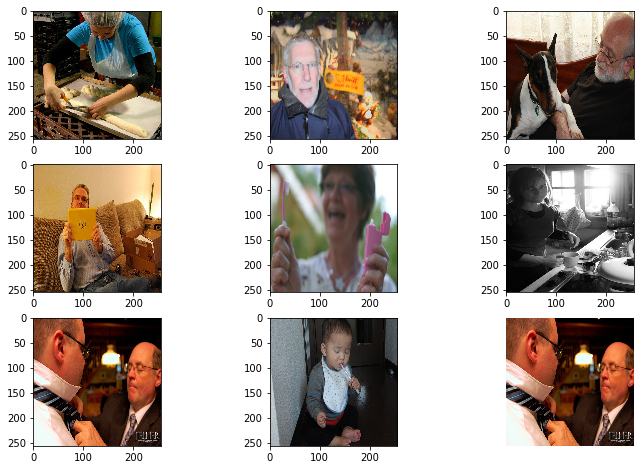

In [29]:
plt.figure(figsize=(12,8))
for pos in range(1, 10):
    plt.subplot(3, 3, pos)
    plt.imshow(images[pos - 1].astype(np.uint8))
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

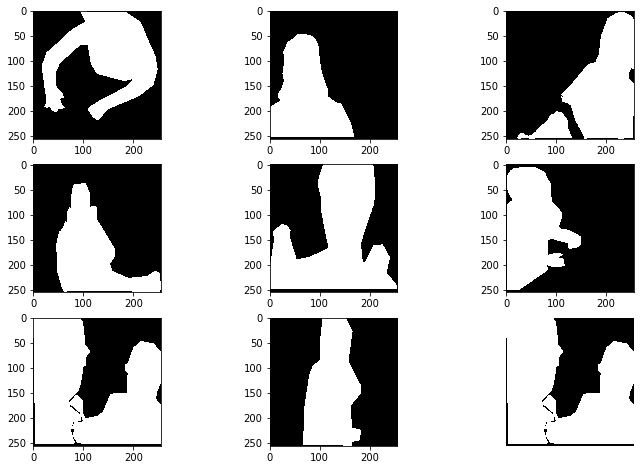

In [30]:
plt.figure(figsize=(12,8))
for pos in range(1, 10):
    plt.subplot(3, 3, pos)
    #mask[mask < 128] = 0
    #mask[mask >= 128] = 1
    plt.imshow((masks[pos - 1] * 255).astype(np.uint8), cmap='gray')
plt.axis('off')

In [33]:
def IOU_calc(y_true, y_false, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_false_f = K.flatten(y_false)
    intersection = K.sum(y_true_f * y_false_f)
    return 2 * (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_false_f) + smooth)

def IOU_loss(y_true, y_false):
    return 1 - IOU_calc(y_true, y_false)

In [51]:
def unet_prototype(img_rows, img_cols):
    inputs = Input(shape=(img_rows, img_cols, 3))
    
    # 256x256x3 -> 128x128x8
    conv1 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # 128x128x8 -> 64x64x16
    conv2 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # 64x64x16 -> 32x32x32
    conv3 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # 32x32x32 -> 16x16x64
    conv4 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # 16x16x64 -> 8x8x128
    conv5 = Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
    
    # 8x8x128 -> 4x4x256
    conv6 = Convolution2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(pool5)
    conv6 = Convolution2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
    
    # 4x4x256 -> 2x2x512
    conv7 = Convolution2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(pool6)
    conv7 = Convolution2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(conv7)
    pool7 = MaxPooling2D(pool_size=(2, 2))(conv7)
    
    # 2x2x512 -> 1x1x1024
    conv8 = Convolution2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(pool7)
    conv8 = Convolution2D(filters=1024, kernel_size=(3, 3), activation='relu', padding='same')(conv8)

    # 1x1x1024 -> 2x2x512
    up9 = Convolution2D(filters=512, kernel_size=(2, 2), padding='same')(UpSampling2D(size=(2, 2))(conv8))
    up9 = concatenate([up9, conv7], axis=-1)
    conv9 = Convolution2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same')(conv9)
    
    # 2x2x512 -> 4x4x256
    up10 = Convolution2D(filters=256, kernel_size=(2, 2), padding='same')(UpSampling2D(size=(2, 2))(conv9))
    up10 = concatenate([up10, conv6], axis=-1)
    conv10 = Convolution2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(up10)
    conv10 = Convolution2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(conv10)
    
    # 4x4x256 -> 8x8x128
    up11 = Convolution2D(filters=128, kernel_size=(2, 2), padding='same')(UpSampling2D(size=(2, 2))(conv10))
    up11 = concatenate([up11, conv5], axis=-1)
    conv11 = Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(up11)
    conv11 = Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv11)
    
    # 8x8x128 -> 16x16x64
    up12 = Convolution2D(filters=64, kernel_size=(2, 2), padding='same')(UpSampling2D(size=(2, 2))(conv11))
    up12 = concatenate([up12, conv4], axis=-1)
    conv12 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(up12)
    conv12 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv12)
    
    # 16x16x64 -> 32x32x32
    up13 = Convolution2D(filters=32, kernel_size=(2, 2), padding='same')(UpSampling2D(size=(2, 2))(conv12))
    up13 = concatenate([up13, conv3], axis=-1)
    conv13 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(up13)
    conv13 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv13)
    
    # 32x32x32 -> 64x64x16
    up14 = Convolution2D(filters=16, kernel_size=(2, 2), padding='same')(UpSampling2D(size=(2, 2))(conv13))
    up14 = concatenate([up14, conv2], axis=-1)
    conv14 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(up14)
    conv14 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv14)
    
    # 64x64x16 -> 128x128x8
    up15 = Convolution2D(filters=8, kernel_size=(2, 2), padding='same')(UpSampling2D(size=(2, 2))(conv14))
    up15 = concatenate([up15, conv1], axis=-1)
    conv15 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(up15)
    conv15 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(conv15)
    
    conv16 = Convolution2D(filters=3, kernel_size=(1, 1), activation='sigmoid')(conv15)
    
    model = Model(inputs=inputs, outputs=conv16)
    
    return model

In [52]:
IMG_ROWS, IMG_COLS = 256, 256

In [53]:
batch_gen = BatchGenerator(data_dir='dataset/dataset_256/')
batch_gen.load_data()
model = unet_prototype(IMG_ROWS, IMG_COLS)
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_loss, metrics=[IOU_calc])

In [54]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
conv2d_120 (Conv2D)              (None, 256, 256, 8)   224         input_5[0][0]                    
____________________________________________________________________________________________________
conv2d_121 (Conv2D)              (None, 256, 256, 8)   584         conv2d_120[0][0]                 
____________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D)  (None, 128, 128, 8)   0           conv2d_121[0][0]                 
___________________________________________________________________________________________

In [55]:
#model.fit(*batch_gen.train_batches)

model.fit_generator(batch_gen.train_batches, steps_per_epoch=1e3, epochs=1)

Epoch 1/1
  80/1000 [=>............................] - ETA: 1013s - loss: 0.4132 - IOU_calc: 0.5868

KeyboardInterrupt: 

In [27]:
import imageio

(224, 224)
<class 'imageio.core.util.Image'>


(-0.5, 223.5, 223.5, -0.5)

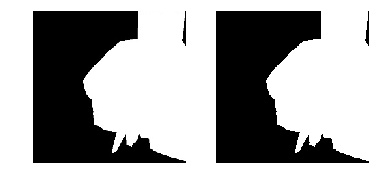

In [107]:
mask_path = '/Users/matt/masters_thesis/utils/tests/test_data/000000000110_mask.jpg'
mask = imageio.imread(mask_path)#.astype(np.float32)
print(mask.shape)
print(type(mask))
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap='gray')
plt.axis('off')
mask[mask < 128] = 0
mask[mask >= 128] = 1
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.axis('off')

In [119]:
from networks.unet_mask_out import Unet

In [121]:
model = Unet.model(IMG_ROWS, IMG_COLS)

In [147]:
model.load_weights('models/unet_batch_1_out_3_epoch_999.hdf5')

In [136]:
batch_gen = BatchGenerator('resized_data_2/')
batch_gen.load_data()
img, mask = next(batch_gen.train_batches)

In [157]:
img, mask = next(batch_gen.train_batches)

In [158]:
img.shape

(0,)

IndexError: index 0 is out of bounds for axis 0 with size 0

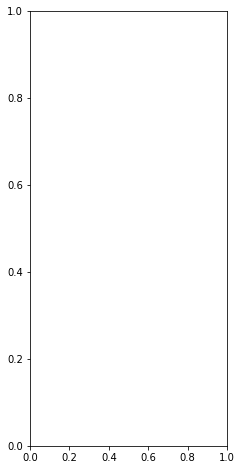

In [154]:
plt.figure(figsize=(12,8))
plt.subplot(1, 3, 1)
plt.imshow(mask[0].astype(np.uint8))

In [148]:
mask_pred = model.predict(img)

In [149]:
mask_pred = mask_pred[0].reshape(*mask_pred[0].shape[:2])

(-0.5, 223.5, 223.5, -0.5)

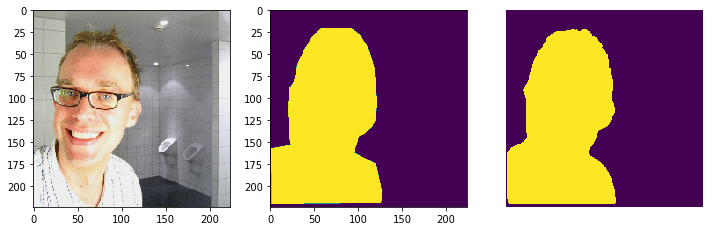

In [152]:
plt.figure(figsize=(12,8))
plt.subplot(1, 3, 1)
plt.imshow(img[0].astype(np.uint8))
plt.subplot(1, 3, 2)
plt.imshow(mask[0].astype(np.uint8))
plt.subplot(1, 3, 3)
plt.imshow(mask_pred.astype(np.uint8))
plt.axis('off')